In [2]:
# ------------------------------------------
# IMPORT AND SETUP
# ------------------------------------------

import sys, os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))) # This construct was reworked with the assistance of AI (DeepSeek) 

#Import the various classes from the src files
from data_import import RawData
raw_data = RawData()

from data_handling import RefinedData
ref_data = RefinedData()

from utils import VisualTable
pretty_table = VisualTable()

from analysis import AnalysedData
analysed_data = AnalysedData()

from graphs import Graphs, PredictiveGraphs
graphic_data = Graphs()
predictive_graphs = PredictiveGraphs()

from predictive_analysis import WeatherAnalyser
predicted_data = WeatherAnalyser()

# ------------------------------------------
# VARIABLES
# ------------------------------------------
    
# Frost API Settings for retrieving weather data 
    # - the first is for the historical data (training data)
    # - the second is for the the more recent data (test data)
FROST_API_CONFIG = {
    'station_id': 'SN68860',  # Weather station ID, can be multiple stations separated by a comma - 'SN68860' is Voll weatherstation
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)', # The measurements to include in the dataset, here: temperautre, precipitation, and wind speed
    'time_range': '2003-08-01/2018-08-01',# The stretch of time to fetch weather data from
    'resolution': 'P1D' # The level of granularity in the weather data. P1D is once per day. P1H is once per hour.
}

FROST_API_CONFIG_TEST = {
    'station_id': 'SN68860',  # Weather station ID, can be multiple stations separated by a comma - 'SN68860' is Voll weatherstation
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)', # The measurements to include in the dataset, here: temperautre, precipitation, and wind speed
    'time_range': '2018-01-01/2024-12-31',# The stretch of time to fetch weather data from
    'resolution': 'P1D' # The level of granularity in the weather data. P1D is once per day. P1H is once per hour.
}

LAT, LON = 63.419, 10.395 # Weather station lat/lon for fetching the weather forecast

# File paths
FILE_PATH = Path('../data/luftkvalitet_trondheim_2003-2018.csv') #Using path/PathLib was suggested by AI (DeepSeek)
FILE_PATH_TEST = Path('../data/luftkvalitet_trondheim_2018-2024.csv')

# Analysis threshold
UPTIME_THRESHOLD = 95 # Minimum uptime (%) for valid air quality data

# The number of standard deviations that defines an outlier
SD_MOD = 3 # A lower number gives a higher number of outliers, recommended range is 2-3

# -- Variables for analysis and graphing
POLLUTANTS = ['CO', 'NO', 'NO2', 'NOx', 'PM10', 'PM2.5'] # The columns that can be found in the air pollutant data
POLLUTANT_VARS = ['CO', 'NO', 'NO2', 'PM10', 'PM2.5'] # Excluding NOx, an aggregate of NO and NO2
WEATHER_VARS = ['temperature (C)', 'wind_speed (m/s)', 'precipitation (mm)'] # The columns that can be found in the weather data

# Y-axis limits and alignment for weather plots: [temp (C), wind (m/s), precip (mm)]
WEATHER_Y_LIMS = [(-20, 30), (0, 20), (0, 100)] 



#All columns: ['Date', 'temperature (C)', 'wind_speed (m/s)', 'precipitation (mm)', 'CO', 'NO', 'NO2', 'PM10', 'PM2.5', 'DayOfYear', 'DayOfYear_sin', 'DayOfYear_cos', 'Weekend', 'Season', 'weekend_effect', 'temp_wind_interaction', 'temp_precip_interaction', 'precip_wind_interaction', 'temperature_wind_speed_interaction', 'temperature_precipitation_interaction', 'wind_speed_precipitation_interaction', 'rolling_temperature_7', 'rolling_wind_speed_7', 'rolling_precipitation_7']
# Available NO lag features: ['NO_lag_1', 'NO_lag_3', 'NO_lag_7', 'NO_lag_30', 'NO_lag_14']
# Available NO2 lag features: ['NO2_lag_1', 'NO2_lag_3', 'NO2_lag_7', 'NO2_lag_30', 'NO2_lag_14']
# Available PM2.5 lag features: ['PM2.5_lag_1', 'PM2.5_lag_3', 'PM2.5_lag_7', 'PM2.5_lag_30', 'PM2.5_lag_14']
# Available PM10 lag features: ['PM10_lag_1', 'PM10_lag_3', 'PM10_lag_7', 'PM10_lag_30', 'PM10_lag_14']

NO_FEATURES = [
    'wind_speed (m/s)',    # Transport/dispersion           Feature importance: 0.11 
    'NO_lag_1',            # Immediate persistence          Feature importance: 0.19
    'NO_lag_7',            # Weekly pattern                 Feature importance: 0.1
    'NO_lag_14',           # Biweekly pattern               Feature importance: 0.08
    'rolling_NO_7',        # Smoothed baseline              Feature importance: 0.45 ★
    'weekend_effect'       # Traffic/industrial variation   Feature importance: 0.06
]

NO2_FEATURES = [
    'wind_speed (m/s)',   # Transport/dispersion control    Feature importance: 0.08
    'NO2_lag_1',          # Immediate persistence           Feature importance: 0.22
    'NO2_lag_7',          # Weekly pattern                  Feature importance: 0.09
    'NO2_lag_14',         # Biweekly pattern                Feature importance: 0.065
    'rolling_NO2_7',      # Smoothed baseline               Feature importance: 0.48 ★
    'weekend_effect'      # Traffic/industrial variation    Feature importance: 0.05
]

PM25_FEATURES = [
    'wind_speed (m/s)',          # Core driver              Feature importance: 0.17
    'PM2.5_lag_1',               # Immediate persistence    Feature importance: 0.2
    'PM2.5_lag_7',               # Weekly pattern           Feature importance: 0.07
    'rolling_wind_speed_7',      # Smoothed wind            Feature importance: 0.05
    'precip_wind_interaction',   # Rain-wind synergy        Feature importance: 0.05
    'wind_speed (m/s)_lag_1',    # Valuable lag             Feature importance: 0.04
    'rolling_PM2.5_7'            # Smoothed baseline        Feature importance: 0.46 ★
]

PM10_FEATURES = [
    'wind_speed (m/s)',          # Core driver              Feature importance: 0.06
    'PM10_lag_1',                # Immediate persistence    Feature importance: 0.22
    'PM10_lag_3',                # Short term persitence    Feature importance: 0.09
    'PM10_lag_7',                # Weekly pattern           Feature importance: 0.07 
    'rolling_PM10_7',            # Smoothed baseline        Feature importance: 0.48 ★
    'precip_wind_interaction',   # Rain-wind synergy        Feature importance: 0.065
    'rolling_wind_speed_7'       # Smoothed wind            Feature importance: 0.045
]




SHOW_ALL_TABLES = False # Shows full tables at every step if True, excluding them if False
SHOW_ALL_GRAPHS = False  # Shows all graphs at every step if True, limits to the bare minimum if False

In [3]:
# ------------------------------------------
# WEATHER DATA - IMPORT AND PROCESSING
# ------------------------------------------

# Run the module for importing the weather data, and save it to a dataframe
df_weather = raw_data.get_met(**FROST_API_CONFIG)

# Check if data was fetched successfully and check for missing values
if df_weather is None:
    print("Failed to fetch weather data.")
else:
    # Report missing values as a dataframe
    missing_df = ref_data.missing_data(df_weather, strategy='report')
    if missing_df is not None:
        print("\nThe following datapoints are missing from the weather data:")
        pretty_table.pretty_data(missing_df)

    # Fill missing values with chosen fill_value
    filled_df = ref_data.missing_data(df_weather, strategy='fill', fill_value=np.nan)
    if filled_df is not None:
        df_weather = filled_df

    if SHOW_ALL_TABLES is True:
        print('\nThe entire table of weather data:')
        pretty_table.pretty_data(df_weather)

# Run the module for importing the weather data for testing, and save it to a dataframe
df_weather_test = raw_data.get_met(**FROST_API_CONFIG_TEST)

# Check if data was fetched successfully and check for missing values
if df_weather_test is None:
    print("Failed to fetch weather data.")
else:
    # Report missing values as a dataframe
    missing_df = ref_data.missing_data(df_weather_test, strategy='report')
    if missing_df is not None:
        print("\nThe following datapoints are missing from the weather data:")
        pretty_table.pretty_data(missing_df)

    # Fill missing values with chosen fill_value
    filled_df = ref_data.missing_data(df_weather_test, strategy='fill', fill_value=np.nan)
    if filled_df is not None:
        df_weather_test = filled_df

    if SHOW_ALL_TABLES is True:
        print('\nThe entire table of weather data for testing:')
        pretty_table.pretty_data(df_weather_test)

# Fetch weather forecast
df_forecast = raw_data.get_forecast(station_id="SN68860")
if df_forecast is None:
    print("Failed to fetch forecast data.")
else:
    if SHOW_ALL_TABLES is True:
        print('\nThe weather forecast:')
        pretty_table.pretty_data(df_forecast)

2025-05-25 10:14:27,481 - INFO - 
Successfully collected 5479 raw observations (5479 unique timestamps) from Frost API

2025-05-25 10:14:27,590 - INFO - 
Processed DataFrame: 5479 rows x 3 parameters (99.3% non-empty values)




The following datapoints are missing from the weather data:


2025-05-25 10:14:30,351 - INFO - 
Successfully collected 2556 raw observations (2556 unique timestamps) from Frost API

2025-05-25 10:14:30,400 - INFO - 
Processed DataFrame: 2556 rows x 3 parameters (99.6% non-empty values)




The following datapoints are missing from the weather data:


In [4]:
# ------------------------------------------
# AIR QUALITY DATA - IMPORT AND PROCESSING
# ------------------------------------------

# Run the module for importing the air quality data, and save it to a dataframe
df_quality = raw_data.get_nilu(UPTIME_THRESHOLD, FILE_PATH)

# Check if data was fetched successfully and check for missing values
if df_quality is None:
    print("Failed to fetch weather data.")
else:
    missing_data = ref_data.missing_data(df_quality)
    if missing_data is not None:
        print("\nThe following datapoints are missing:")
        pretty_table.pretty_data(missing_data)

# Displaying the air quality data as a table
if SHOW_ALL_TABLES is True:
    print('\nThe entire table of air pollution data (pollutants are in µg/m³):')
    pretty_table.pretty_data(df_quality)

# Run the module for importing the air quality data for testing, and save it to a dataframe
df_quality_test = raw_data.get_nilu(UPTIME_THRESHOLD, FILE_PATH_TEST)

# Check if data was fetched successfully and check for missing values
if df_quality_test is None:
    print("Failed to fetch weather data.")
else:
    missing_data = ref_data.missing_data(df_quality_test)
    if missing_data is not None:
        print("\nThe following datapoints are missing:")
        pretty_table.pretty_data(missing_data)

# Displaying the air quality data as a table
if SHOW_ALL_TABLES is True:
    print('\nThe entire table of air pollution data (pollutants are in µg/m³):')
    pretty_table.pretty_data(df_quality_test)

2025-05-25 10:14:32,503 - INFO - 
Successfully collected and processed 5480 rows of data from 
../data/luftkvalitet_trondheim_2003-2018.csv

2025-05-25 10:14:32,511 - INFO - 
Processed DataFrame: 5480 rows x 6 parameters (60.2% non-empty values)




The following datapoints are missing:


2025-05-25 10:14:33,725 - INFO - 
Successfully collected and processed 2557 rows of data from 
../data/luftkvalitet_trondheim_2018-2024.csv

2025-05-25 10:14:33,731 - INFO - 
Processed DataFrame: 2557 rows x 5 parameters (85.6% non-empty values)




The following datapoints are missing:



Standard deviation of weather data



Standard deviation of air pollution data



Total average(mean) of weather data



Total average(mean) of air pollution data


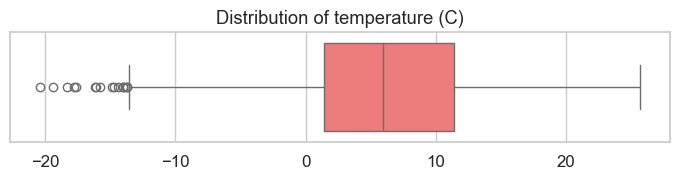

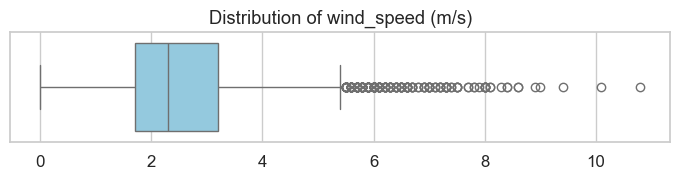

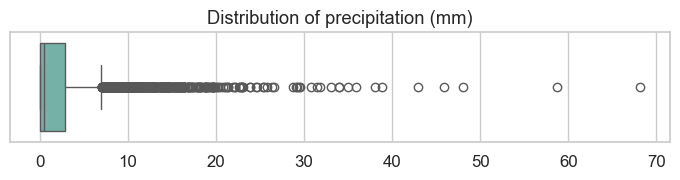

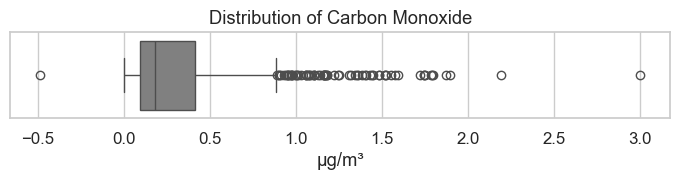

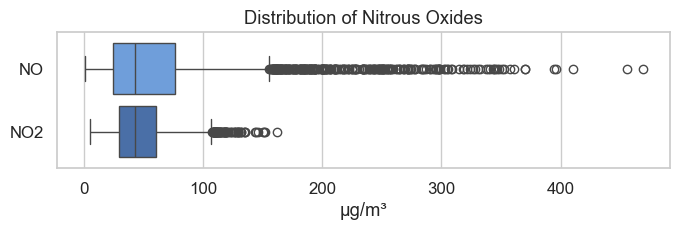

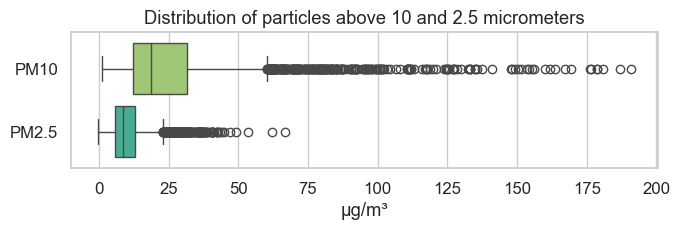

In [5]:
# ------------------------------------------
# DATA AND PATTERN ANALYSIS
# ------------------------------------------

# Standard deviations of weather data
weather_standard_deviation = analysed_data.standard_deviation(df_weather, WEATHER_VARS)
print('\nStandard deviation of weather data')
pretty_table.pretty_data(weather_standard_deviation)

# Standard deviations of air pollutant data
pollutants_standard_deviation = analysed_data.standard_deviation(df_quality, POLLUTANTS)
print('\nStandard deviation of air pollution data')
pretty_table.pretty_data(pollutants_standard_deviation)

# Total average for weather data
weather_average = analysed_data.total_average(df_weather, WEATHER_VARS)
print('\nTotal average(mean) of weather data')
pretty_table.pretty_data(weather_average)

# Total average for pollution data
pollution_average = analysed_data.total_average(df_quality, POLLUTANTS)
print('\nTotal average(mean) of air pollution data')
pretty_table.pretty_data(pollution_average)

# Outliers of weather data
weather_outliers, weather_x_outliers = analysed_data.outliers(df_weather, WEATHER_VARS, weather_standard_deviation, weather_average, SD_MOD)
if SHOW_ALL_TABLES is True:
    print('\nOutliers from the weather data')
    pretty_table.pretty_data(weather_outliers)
    print('\nWeather data without outliers')
    pretty_table.pretty_data(weather_x_outliers)

#Outliers of air pollution data
pollution_outliers, pollution_x_outliers = analysed_data.outliers(df_quality, POLLUTANTS, pollutants_standard_deviation, pollution_average, SD_MOD)
if SHOW_ALL_TABLES is True:
    print('\nOutliers from the pollution data')
    pretty_table.pretty_data(pollution_outliers)
    print('\nPollution data without outliers')
    pretty_table.pretty_data(pollution_x_outliers)

# Averages of weather data
df_average_weather = analysed_data.averages(weather_x_outliers, WEATHER_VARS)
if SHOW_ALL_TABLES is True:
    print('\nTable of weekly averages for weather data:')
    pretty_table.pretty_data(df_average_weather)

# Averages of air pollutant data
df_average_pollutants = analysed_data.averages(pollution_x_outliers, POLLUTANTS)
if SHOW_ALL_TABLES is True:
    print('\nTable of weekly averages for air pollution (pollutants are in µg/m³):')
    pretty_table.pretty_data(df_average_pollutants)

# Box plots of weather variables
colors = ['#FF6B6B','skyblue','#6BBBAE' ]
for column, color in zip(WEATHER_VARS, colors):
    analysed_data.box_plots(
        df = df_weather,
        columns = [column],
        color = color,
        figsize = [7, 2]
    )

# Box plot of Carbon monoxide
analysed_data.box_plots(
    df = df_quality,
    columns = 'CO',
    color = 'grey',
    figsize = (7, 2),
    title = 'Distribution of Carbon Monoxide',
    x_label = 'µg/m³'
)

# Box plot of Nitrous Oxides
analysed_data.box_plots(
    df = df_quality,
    columns = ['NO', 'NO2'],
    color = ['#5D9CEC', '#3A6CB7'],
    figsize = (7,2.5),
    title = 'Distribution of Nitrous Oxides',
    x_label = 'µg/m³'
)

# Box plot of Particles
analysed_data.box_plots(
    df = df_quality,
    columns = ['PM10', 'PM2.5'],
    color = ['#A0D468', '#37BC9B'],
    figsize = (7,2.5),
    title = 'Distribution of particles above 10 and 2.5 micrometers',
    x_label = 'µg/m³'
)

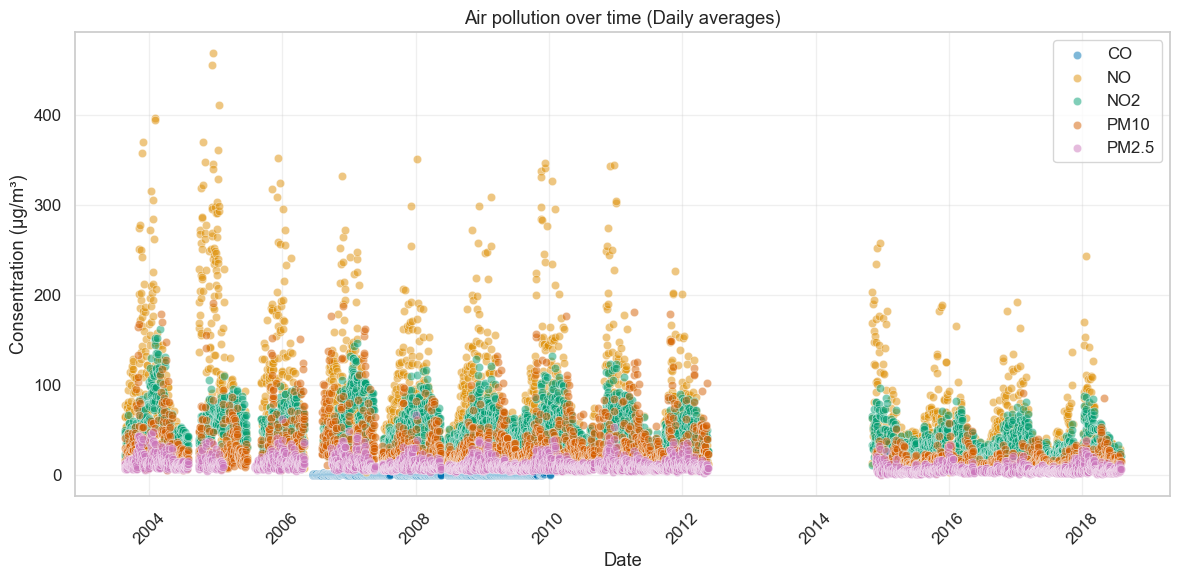

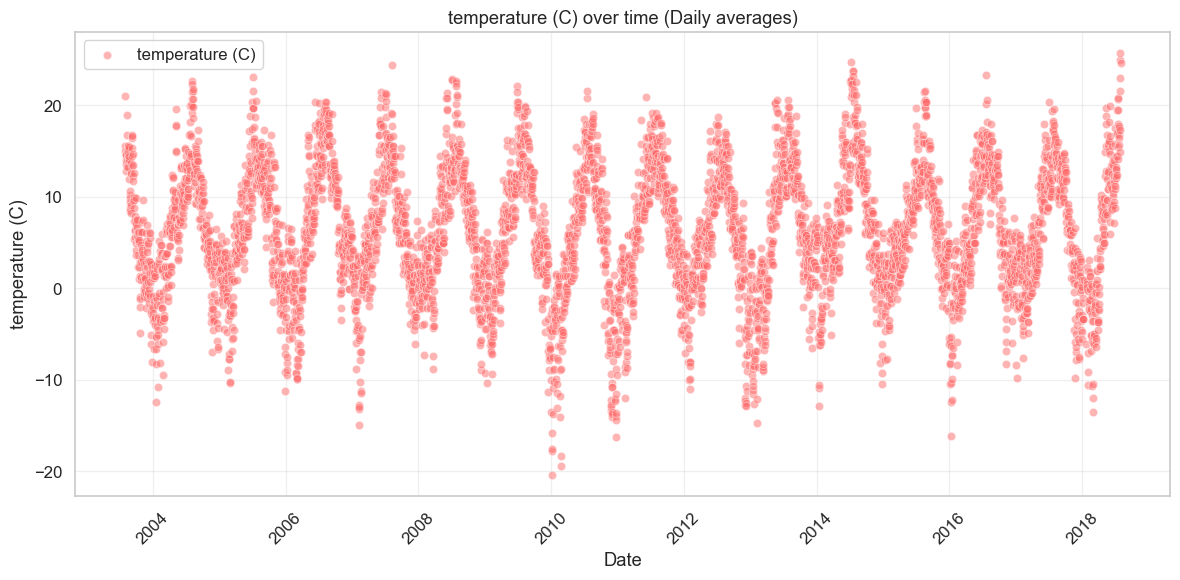

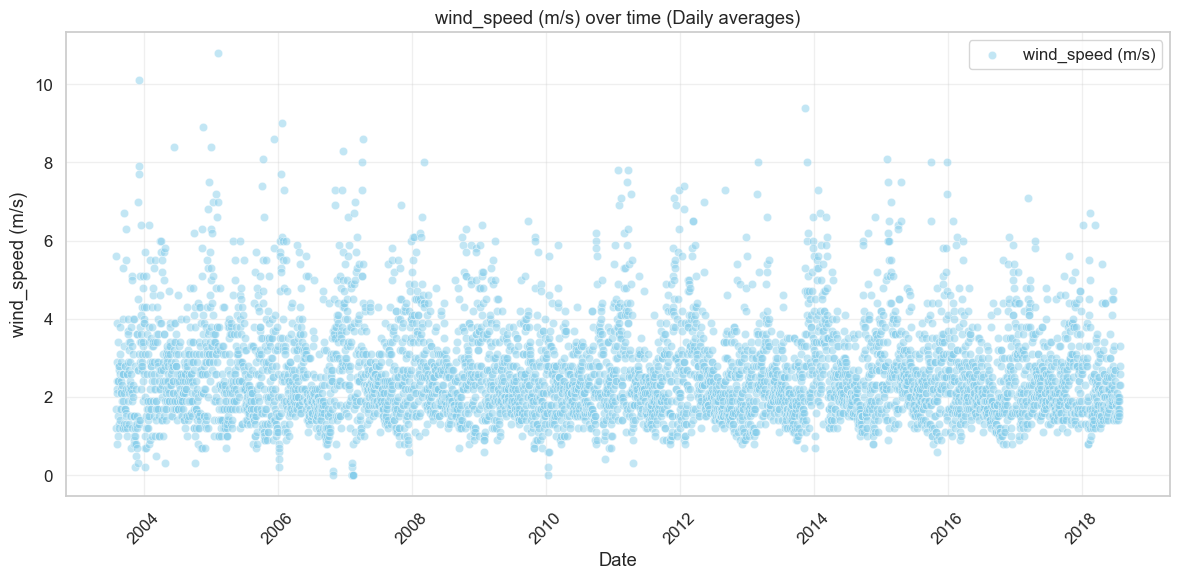

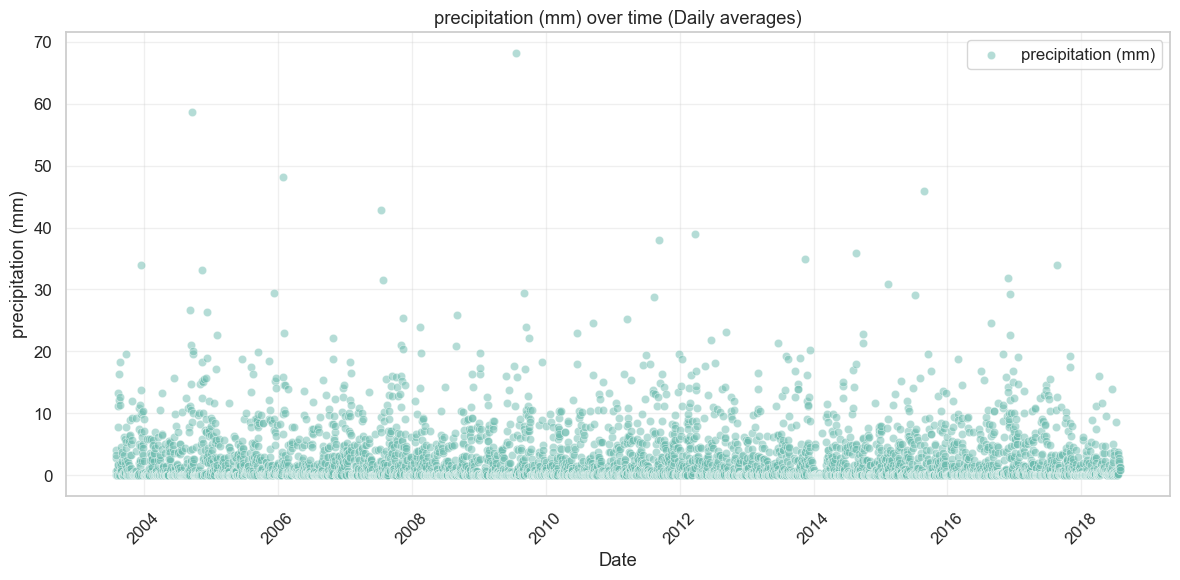

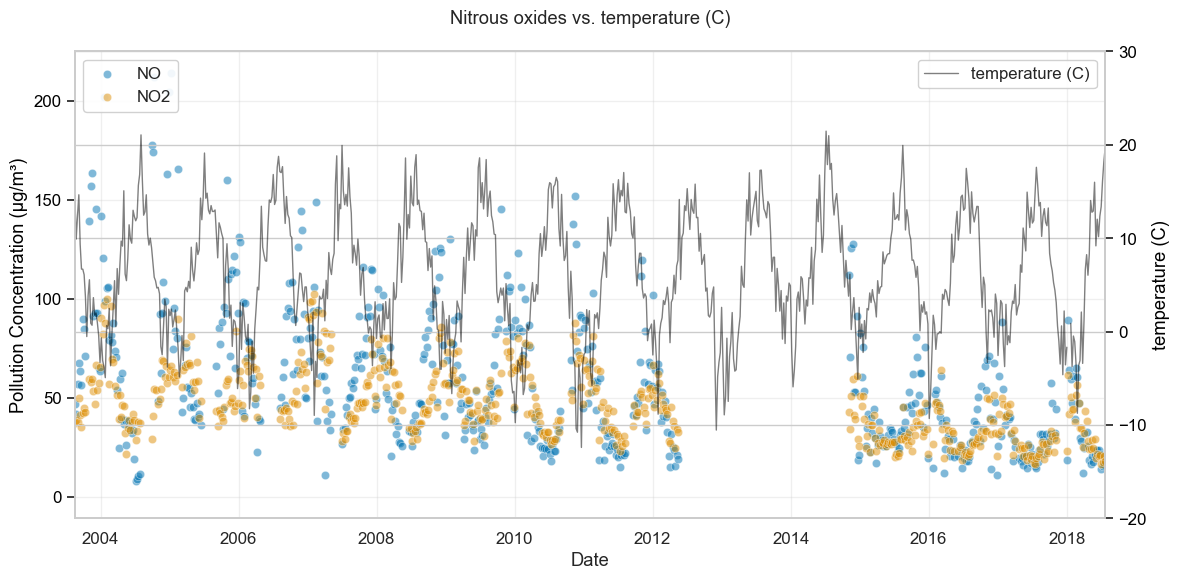

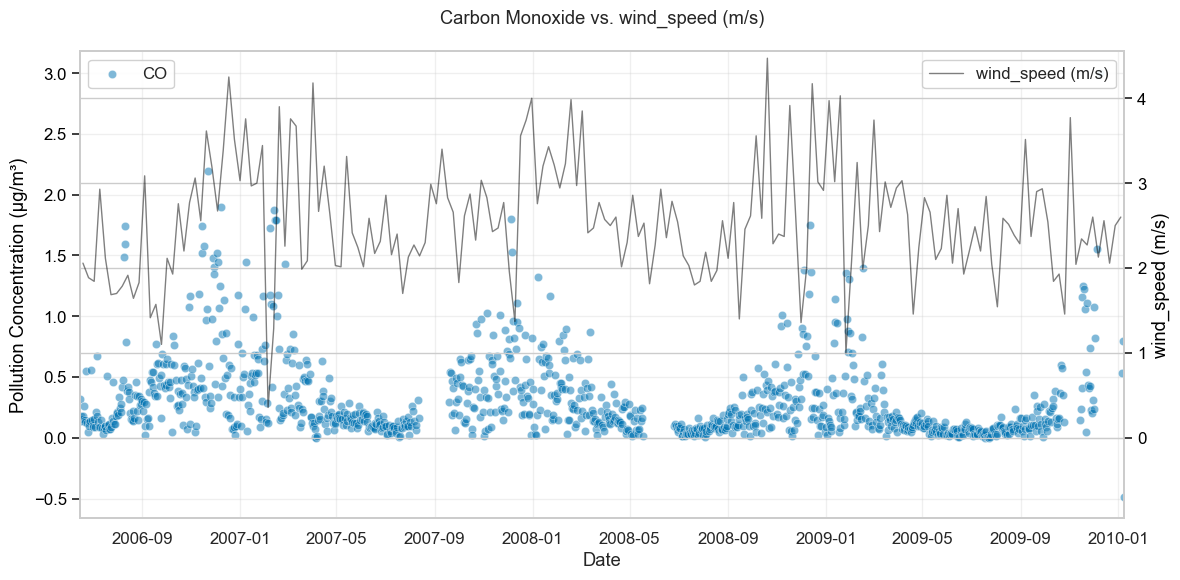

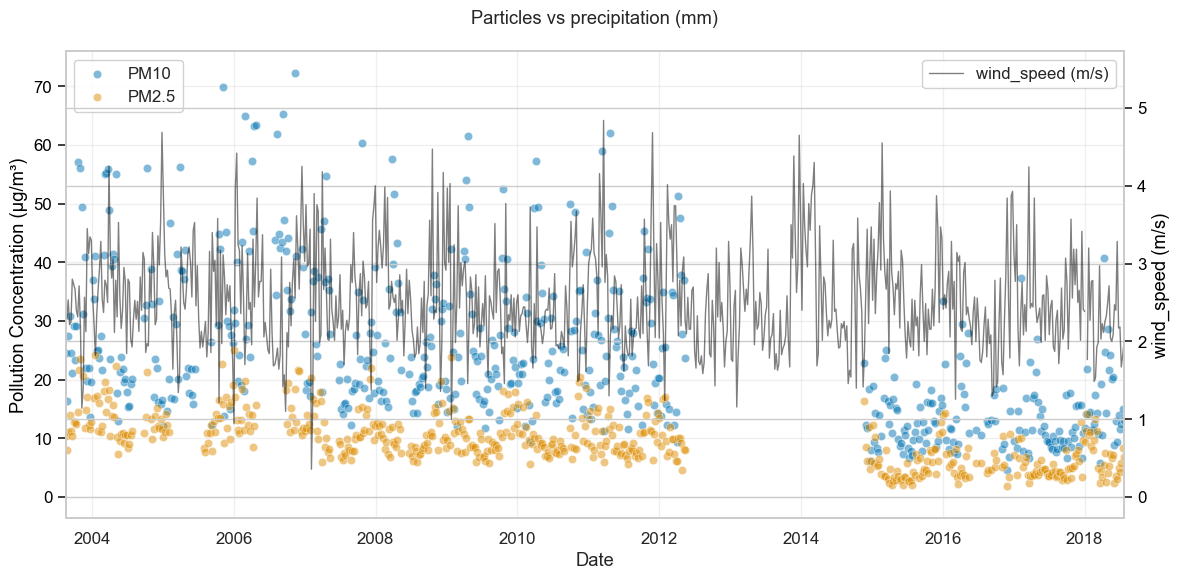

In [6]:
# ------------------------------------------
# DATA VISUALISATION AND GRAPHING
# ------------------------------------------

# Creating a sattergraph for the air quality data
graphic_data.dot_graph(
    df_quality, 
    POLLUTANT_VARS, 
    'Air pollution over time (Daily averages)', 
    'Date', 
    'Consentration (µg/m³)'
)

if SHOW_ALL_GRAPHS is True:
    # Creatingg a scattergraph of Nitrous Oxides
    graphic_data.dot_graph(
        df_quality, 
        ['NO', 'NO2'], 
        'Nitrous oxides over time (Daily averages)', 
        'Date', 
        'Consentration (µg/m³)'
    )

    # Creatingg a scattergraph of Carbon monoxide
    graphic_data.dot_graph(
        df_quality, 
        ['CO'], 
        'Carbon monoxide over time (Daily averages)', 
        'Date', 
        'Consentration (µg/m³)'
    )

    # Creatingg a scattergraph of particles over time
    graphic_data.dot_graph(
        df_quality, 
        ['PM2.5', 'PM10'], 
        'Particles over time (Daily averages)', 
        'Date', 
        'Consentration (µg/m³)'
    )

    # Creating a scattergraph for weekly averages of air quality data
    graphic_data.dot_graph(
        df_average_pollutants, 
        POLLUTANT_VARS, 
        'Air pollution over time (weekly averages)', 
        'Date', 
        'Consentration (µg/m³)'
    )

# Creating a scattergraph for each of the the weather data variables
colors = ['#FF6B6B','skyblue','#6BBBAE' ]
for column, color in zip(WEATHER_VARS, colors):
    graphic_data.dot_graph(
        df=df_weather,
        columns=[column],  
        title=f'{column} over time (Daily averages)', 
        x_axis='Date',
        y_axis=column,
        color=color  
    )

if SHOW_ALL_GRAPHS is True:
    # Creating a scattergraph for each of the the weather data variables for weekly averages
    for column in WEATHER_VARS:
        graphic_data.dot_graph(
            df=df_average_weather,
            columns=[column],
            title=f'{column} over time (Weekly averages)', 
            x_axis='Date',
            y_axis=column  
        )

# Creating a comparative graph of Nitrous oxides vs temperature
graphic_data.comparative_graph(
    df=df_average_pollutants,
    columns=['NO', 'NO2'], 
    df_predictor=df_average_weather,
    predictor='temperature (C)',
    title=f'Nitrous oxides vs. temperature (C)',  
    x_axis='Date',
    y_axis='Pollution Concentration (µg/m³)',
    y_lims=(-20,30),
    zero_align=False
)

if SHOW_ALL_GRAPHS is True:
    # Creating a comparative graph of Carbon Monoxide vs temperature
    graphic_data.comparative_graph(
        df=df_quality,
        columns=['CO'], 
        df_predictor=df_average_weather,
        predictor='temperature (C)',
        title=f'Carbon Monoxide vs. temperature (C)',  
        x_axis='Date',
        y_axis='Pollution Concentration (µg/m³)',
        y_lims=(-20,30),
        zero_align=False
    )

    # Creating a comparative graph of Nitrous oxides vs wind speed
    graphic_data.comparative_graph(
        df=df_average_pollutants,
        columns=['NO', 'NO2'], 
        df_predictor=df_average_weather,
        predictor='wind_speed (m/s)',
        title=f'Nitrous oxides vs. wind_speed (m/s)',  
        x_axis='Date',
        y_axis='Pollution Concentration (µg/m³)',
        y_lims=(0,5.5),
        zero_align=True
    )

# Creating a comparative graph of Carbon Monoxide vs wind speed
graphic_data.comparative_graph(
    df=df_quality,
    columns=['CO'], 
    df_predictor=df_average_weather,
    predictor='wind_speed (m/s)',
    title=f'Carbon Monoxide vs. wind_speed (m/s)',  
    x_axis='Date',
    y_axis='Pollution Concentration (µg/m³)',
    y_lims=(0,5.5),
    zero_align=True
)

# Creating a comparative graph of partiles vs precipitation
graphic_data.comparative_graph(
    df=df_average_pollutants,
    columns=['PM10', 'PM2.5'], 
    df_predictor=df_average_weather,
    predictor='wind_speed (m/s)',
    title=f'Particles vs precipitation (mm)',  
    x_axis='Date',
    y_axis='Pollution Concentration (µg/m³)',
    y_lims=(0,6),
    zero_align=True
)


In [7]:
# ------------------------------------------
# PREDICTIVE ANALYSIS
# ------------------------------------------

# Load training data (up to Dec 2017)
merged_data = predicted_data.load_and_merge_data(
    weather_x_outliers[weather_x_outliers['Date'] < '2018-01-01'],
    pollution_x_outliers[pollution_x_outliers['Date'] < '2018-01-01'],
    WEATHER_VARS,
    POLLUTANT_VARS,
    'train'
)

# Load test data (Jan 2018 onward)
merged_data_test = predicted_data.load_and_merge_data(
    df_weather_test[df_weather_test['Date'] >= '2018-01-01'],
    df_quality_test[df_quality_test['Date'] >= '2018-01-01'],
    WEATHER_VARS,
    POLLUTANT_VARS,
    'test'
)

# Create simple predictive models for each weather variable
model_temp = predicted_data.create_model(degree=4)
predicted_data.safe_fit(
    model_temp,
    merged_data[['DayOfYear']],
    merged_data['temperature (C)']
)

model_precip = predicted_data.create_model(degree=4)
predicted_data.safe_fit(
    model_precip,
    merged_data[['DayOfYear']],
    merged_data['precipitation (mm)']
)

model_wind = predicted_data.create_model(degree=4)
predicted_data.safe_fit(
    model_wind,
    merged_data[['DayOfYear']],
    merged_data['wind_speed (m/s)']
)

# Use models to create simple predictions using only 'DayOfYear'
last_date = pd.to_datetime(df_weather['Date'].max())
last_api_date = pd.to_datetime(df_forecast['Date'].max())
days_to_predict = (last_api_date - last_date).days

temp_forecast = predicted_data.predict_future(model_temp, last_date, days_to_predict)
precip_forecast = predicted_data.predict_future(model_precip, last_date, days_to_predict)
wind_forecast = predicted_data.predict_future(model_wind, last_date, days_to_predict)

# Function to run a target pollutant through creating a model and testing it, with multiple features
def run_full_analysis(target, features, train_data, test_data):

    """
    Trains and evaluates a model for a target pollutant.
    
    Args:
        target (str): Pollutant name (e.g., 'NO2')
        features (list): Feature columns for the model
        train_data (pd.DataFrame): Training data
        test_data (pd.DataFrame): Test data
        
    Returns:
        tuple: (model, predictions, filtered_test_data)
            - model: Trained RandomForestRegressor
            - predictions: Model predictions on test data
            - filtered_test_data: Test data with predictions/errors
    """

    if train_data.empty or test_data.empty:
        raise ValueError("Train/test data cannot be empty!")
    
    missing = [f for f in features if f not in train_data.columns]
    if missing:
        available = [f for f in features if f in train_data.columns]
        similar = [col for col in train_data.columns 
                  if any(f in col for f in missing)]
        
        print(f"⚠️ Missing features: {missing}")
        print(f"✅ Available features: {available}")
        print(f"🔍 Similar existing columns: {similar}")
        raise ValueError("Fix features before proceeding")

    model = predicted_data.train_model(train_data, target, features)
    predictions, filtered_test_data, mse, r2 = predicted_data.evaluate_model(model, test_data, target, features, train_data)

    # Add error calculation
    filtered_test_data = filtered_test_data.copy()
    filtered_test_data[f'{target}_pred'] = predictions
    filtered_test_data[f'{target}_error'] = abs(filtered_test_data[target] - predictions)

    if mse is not None and SHOW_ALL_TABLES is False:
        print(f"\n{target} Model Performance:")
        print(f"MSE: {mse:.2f}, R²: {r2:.2f}")
        
        # Lag feature diagnostics
        lag_features = [f for f in train_data.columns if f.startswith(f"{target}_lag")]
        print(f"Available {target} lag features:", lag_features)
    
        # Persistence correlation - using filtered data
        if f"{target}_lag_1" in filtered_test_data.columns:
            valid_idx = filtered_test_data[f"{target}_lag_1"].notna()
            persistence_corr = np.corrcoef(
                predictions[valid_idx],
                filtered_test_data.loc[valid_idx, f"{target}_lag_1"]
            )[0,1]
            print(f"Model correlation with persistence: {persistence_corr:.2f}")

        valid_mask = test_data[[target, f"{target}_lag_1"]].notna().all(axis=1)
        if valid_mask.any():
            persistence_mse = mean_squared_error(
                test_data.loc[valid_mask, target],
                test_data.loc[valid_mask, f"{target}_lag_1"]
            )
            print(f"Persistence MSE: {persistence_mse:.2f} (Your model: {mse:.2f})")
        else:
            print("⚠️ Persistence MSE: Insufficient data (all lag_1 values are NaN)")

    return model, predictions, filtered_test_data

no_model, no_predictions, no_test = run_full_analysis('NO', NO_FEATURES, merged_data, merged_data_test)
no2_model, no2_predictions, no2_test = run_full_analysis('NO2', NO2_FEATURES, merged_data, merged_data_test)
pm25_model, pm25_predictions, pm25_test = run_full_analysis('PM2.5', PM25_FEATURES, merged_data, merged_data_test)
pm10_model, pm10_predictions, pm10_test = run_full_analysis('PM10', PM10_FEATURES, merged_data, merged_data_test)

if SHOW_ALL_TABLES is True:
    no_worst = no_test.nlargest(5, 'NO_error')[['Date', 'NO', 'NO_pred', 'NO_error'] + NO_FEATURES]
    no_worst['Date'] = no_worst['Date'].dt.date
    no2_worst = no2_test.nlargest(5, 'NO2_error')[['Date', 'NO2', 'NO2_pred', 'NO2_error'] + NO2_FEATURES]
    no2_worst['Date'] = no2_worst['Date'].dt.date
    pm25_worst = pm25_test.nlargest(5, 'PM2.5_error')[['Date', 'PM2.5', 'PM2.5_pred', 'PM2.5_error'] + PM25_FEATURES]
    pm25_worst['Date'] = pm25_worst['Date'].dt.date
    pm10_worst = pm10_test.nlargest(5, 'PM10_error')[['Date', 'PM10', 'PM10_pred', 'PM10_error'] + PM10_FEATURES]
    pm10_worst['Date'] = pm10_worst['Date'].dt.date
    
    # Print results
    print("\nNO Worst Cases:")
    pretty_table.pretty_data(no_worst)
    
    print("\nNO2 Worst Cases:")
    pretty_table.pretty_data(no2_worst)
    
    print("\nPM2.5 Worst Cases:")
    pretty_table.pretty_data(pm25_worst)
    
    print("\nPM10 Worst Cases:")
    pretty_table.pretty_data(pm10_worst)

print('***********')


2025-05-25 10:14:42,040 - INFO - 
Merged data shape: (5267, 10), 
Available weather: ['temperature (C)', 'wind_speed (m/s)', 'precipitation (mm)'], 
Available pollutants: ['CO', 'NO', 'NO2', 'PM10', 'PM2.5']

2025-05-25 10:14:42,109 - INFO - Interpolated 108 missing values in CO
2025-05-25 10:14:42,117 - INFO - Interpolated 229 missing values in NO
2025-05-25 10:14:42,123 - INFO - Interpolated 197 missing values in NO2
2025-05-25 10:14:42,129 - INFO - Interpolated 575 missing values in PM10
2025-05-25 10:14:42,136 - INFO - Interpolated 484 missing values in PM2.5
2025-05-25 10:14:42,158 - INFO - 
Skipping missing pollutant columns: {'CO'}
2025-05-25 10:14:42,158 - INFO - 
Merged data shape: (2556, 9), 
Available weather: ['temperature (C)', 'wind_speed (m/s)', 'precipitation (mm)'], 
Available pollutants: ['NO', 'NO2', 'PM10', 'PM2.5']

2025-05-25 10:14:42,196 - INFO - Interpolated 97 missing values in NO
2025-05-25 10:14:42,202 - INFO - Interpolated 96 missing values in NO2
2025-05-25












NO Model Performance:
MSE: 163.13, R²: 0.60
Available NO lag features: ['NO_lag_1', 'NO_lag_3', 'NO_lag_7', 'NO_lag_30', 'NO_lag_14']
Model correlation with persistence: 0.78
Persistence MSE: 385.84 (Your model: 163.13)

NO2 Model Performance:
MSE: 59.19, R²: 0.64
Available NO2 lag features: ['NO2_lag_1', 'NO2_lag_3', 'NO2_lag_7', 'NO2_lag_30', 'NO2_lag_14']
Model correlation with persistence: 0.79
Persistence MSE: 112.43 (Your model: 59.19)

PM2.5 Model Performance:
MSE: 6.77, R²: 0.65
Available PM2.5 lag features: ['PM2.5_lag_1', 'PM2.5_lag_3', 'PM2.5_lag_7', 'PM2.5_lag_30', 'PM2.5_lag_14']
Model correlation with persistence: 0.82
Persistence MSE: 13.04 (Your model: 6.77)

PM10 Model Performance:
MSE: 55.32, R²: 0.51
Available PM10 lag features: ['PM10_lag_1', 'PM10_lag_3', 'PM10_lag_7', 'PM10_lag_30', 'PM10_lag_14']
Model correlation with persistence: 0.82
Persistence MSE: 94.66 (Your model: 55.32)
***********


In [8]:
'''# ------------------------------------------
# INTERACTIVE DATA VISUALIZATION
# ------------------------------------------
import plotly.io as pio
pio.renderers.default = "notebook_connected" 

from graph_test import InteractiveGraphs
ig = InteractiveGraphs(weather_vars=WEATHER_VARS)

# Daily pollution (toggle pollutants)
ig.dot_graph(df_quality, POLLUTANTS, 'Air pollution (Daily)', 'Date', 'Concentration (µg/m³)')

# Weekly pollution (toggle pollutants)
ig.dot_graph(df_average_pollutants, POLLUTANTS, 'Air pollution (Weekly)', 'Date', 'Concentration (µg/m³)')

# Comparative graphs (now with dropdown)
ig.comparative_graph(
    df=df_quality,
    columns=POLLUTANTS,
    df_predictor=df_weather,
    predictor=WEATHER_VARS[0],  # Default to first variable
    title='Pollution vs Weather',
    x_axis='Date',
    y_axis='Pollution (µg/m³)',
    y_lims=WEATHER_Y_LIMS[0],  # Use first set of limits
    zero_align=ZERO_ALIGN[0]   # Use first alignment setting
)'''

'# ------------------------------------------\n# INTERACTIVE DATA VISUALIZATION\n# ------------------------------------------\nimport plotly.io as pio\npio.renderers.default = "notebook_connected" \n\nfrom graph_test import InteractiveGraphs\nig = InteractiveGraphs(weather_vars=WEATHER_VARS)\n\n# Daily pollution (toggle pollutants)\nig.dot_graph(df_quality, POLLUTANTS, \'Air pollution (Daily)\', \'Date\', \'Concentration (µg/m³)\')\n\n# Weekly pollution (toggle pollutants)\nig.dot_graph(df_average_pollutants, POLLUTANTS, \'Air pollution (Weekly)\', \'Date\', \'Concentration (µg/m³)\')\n\n# Comparative graphs (now with dropdown)\nig.comparative_graph(\n    df=df_quality,\n    columns=POLLUTANTS,\n    df_predictor=df_weather,\n    predictor=WEATHER_VARS[0],  # Default to first variable\n    title=\'Pollution vs Weather\',\n    x_axis=\'Date\',\n    y_axis=\'Pollution (µg/m³)\',\n    y_lims=WEATHER_Y_LIMS[0],  # Use first set of limits\n    zero_align=ZERO_ALIGN[0]   # Use first alignment

In [9]:
# ------------------------------------------
# SAVE DATA TO FILE
# ------------------------------------------

# The following block of code was written with assistance from AI
    # - Purpose: AI was used to help pinpoint the correct folder location.
    # - AI Tool: DeepSeek

#df_weather.to_csv('../data/refined_weather_data.csv', encoding='utf-8', index=False)
#df_quality.to_csv('../data/refined_air_qualty_data.csv', encoding='utf-8', index=False)
